#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile, RFECV
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

#### Dataset

In [3]:
X = pd.read_csv('../data_students/labeled_data/X_train.csv')
X_test  = pd.read_csv('../data_students/labeled_data/X_test.csv')
y = pd.read_csv('../data_students/labeled_data/y_train.csv', header=None)
y_test  = pd.read_csv('../data_students/labeled_data/y_test.csv', header=None)

# Getting rid of the column 'img_filename'
X = X.drop(columns=['img_filename'])
X_test  = X_test.drop(columns=['img_filename'])

y      = y.squeeze()
y_test = y_test.squeeze()

profession_categories = [['food production', 'administration and governance', 'services', 'ressource extraction', 'craftsmanship', 'manufacturing']]
ordinal_categories = ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']
normally_distributed_categories = ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 'vitamin D', 'weight']

# Data pre-processing

#### Transformation

**Outliers handling**

Cholesterol has really bad outliers, so we remove them and it improves the model.

In [4]:
cholesterol_indexes = X[X['cholesterol'] < 5].index
X = X.drop(cholesterol_indexes).reset_index(drop=True)
y = y.drop(cholesterol_indexes).reset_index(drop=True)

**Ordinal encoding**

Since sarsaparilla, smurfberry liquor and smurfin donuts have some ordinality (from very low to very high) we can transform it with values from 0 to 5.

In [5]:
ordinal_encoder = OrdinalEncoder(categories=[['Very low', 'Low', 'Moderate', 'High', 'Very high']])
for category in ordinal_categories:
    X[category]      = ordinal_encoder.fit_transform(X[[category]])
    X_test[category] = ordinal_encoder.transform(X_test[[category]])

**One-hot encoder** for Profession category

We create a vector of values which are set to zeros except for the profession value of the item.

In [6]:
one_hot_encoder = OneHotEncoder(categories=profession_categories, sparse_output=False)

profession_encoded_train = one_hot_encoder.fit_transform(X[['profession']])
profession_encoded_train_df = pd.DataFrame(profession_encoded_train, columns=one_hot_encoder.get_feature_names_out(['profession']))
X = pd.concat([X.drop('profession', axis=1), profession_encoded_train_df], axis=1)

profession_encoded_test = one_hot_encoder.transform(X_test[['profession']])
profession_encoded_test_df = pd.DataFrame(profession_encoded_test, columns=one_hot_encoder.get_feature_names_out(['profession']))
X_test = pd.concat([X_test.drop('profession', axis=1), profession_encoded_test_df], axis=1)

### Standardization

In [7]:
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Feature selection

### Correlation with target

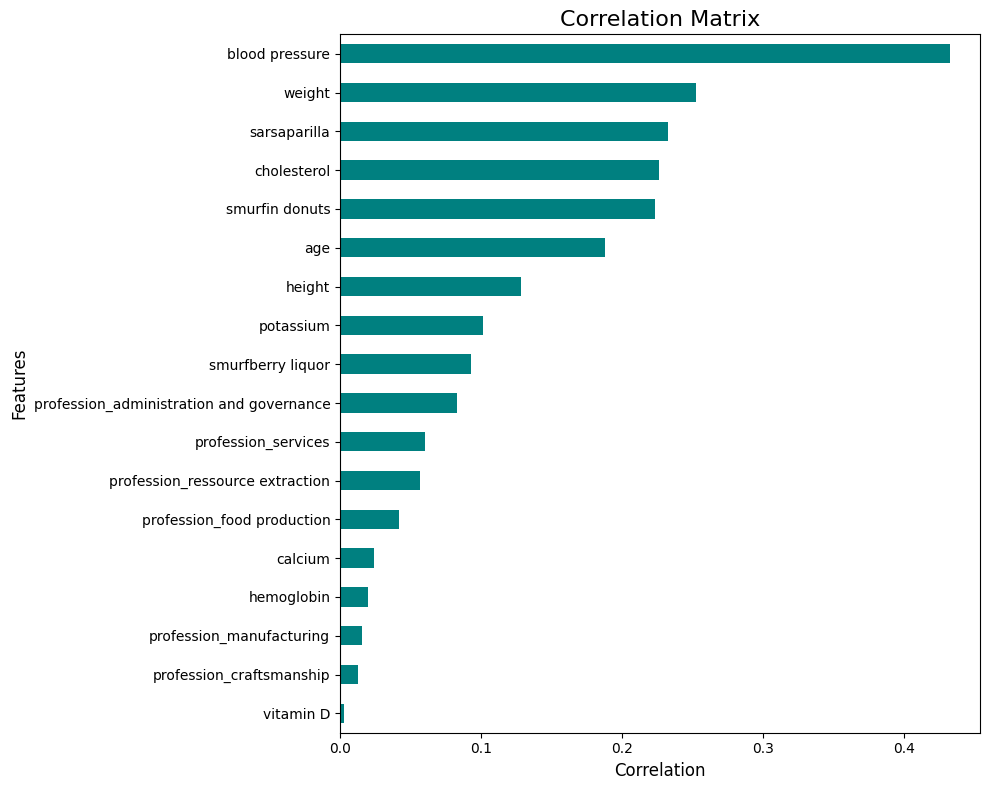

{'X':      blood pressure    weight  sarsaparilla  cholesterol  smurfin donuts  \
 0         -0.400520 -0.962435     -0.349855    -1.565069       -0.312754   
 1         -1.225008 -0.169138     -0.349855    -0.458686        0.454915   
 2          0.040415 -0.987849      2.071660    -0.487683       -1.848093   
 3         -0.858066  0.209054     -0.349855     0.532526        0.454915   
 4          0.261637  0.010579     -1.157027     0.711818        0.454915   
 ..              ...       ...           ...          ...             ...   
 994        0.193685 -0.319205      2.071660    -0.564056       -0.312754   
 995       -0.983400 -0.523731      0.457316    -1.558535        0.454915   
 996       -1.003031 -1.716399     -0.349855    -0.643696       -0.312754   
 997       -0.672329 -1.991118     -0.349855     0.712635       -0.312754   
 998        2.114470  0.966649     -0.349855     0.995664        1.222584   
 
           age    height  potassium  smurfberry liquor  
 0   -1.0249

In [21]:
# Correlation matrix
def correl(X, y, k, plot=True):
    correlation_matrix = X.corrwith(y)

    if plot:
        plt.figure(figsize=(10, 8))  # Augmentez la taille de la figure pour plus d'espace
        correlation_matrix.abs().sort_values().plot(kind='barh', color='teal')

        plt.title('Correlation Matrix', fontsize=16)  # Titre plus visible
        plt.xlabel('Correlation', fontsize=12)  # Augmentez la taille du texte des axes
        plt.ylabel('Features', fontsize=12)

        # Ajustez les marges pour éviter les coupures
        plt.tight_layout()

        # Sauvegarde avec ajustement des marges pour l'image exportée
        plt.savefig('../figures/correlation_target.pdf', bbox_inches='tight')
        plt.show()

    # Selecting the top 10 features
    top_features = correlation_matrix.abs().sort_values(ascending=False).head(k).index
    X_train_selected = X[top_features]

    return {'X': X_train_selected, 'top_features': top_features}
correl(X, y, 9)

#### Correlation between features

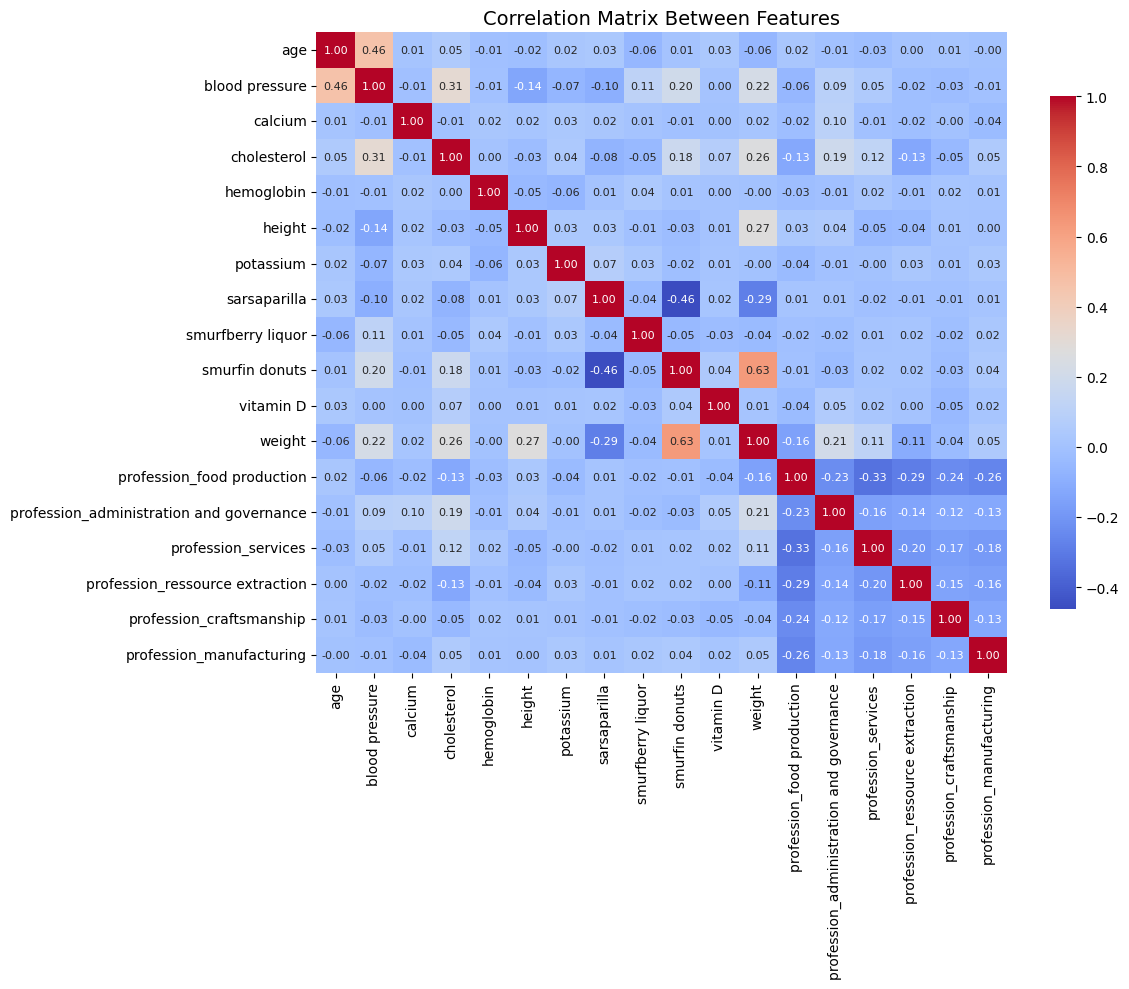

In [19]:
# Correlation matrix between features
correlation_matrix = X.corr()
plt.figure(figsize=(12, 10))  # Augmentez légèrement la taille pour plus d'espace
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            annot_kws={"size": 8}, cbar_kws={'shrink': 0.8})  # Ajustez la taille des annotations
plt.title('Correlation Matrix Between Features', fontsize=14)

# Ajustez les marges pour éviter que les noms soient coupés
plt.tight_layout()

# Sauvegarde
plt.savefig('../figures/correlation_matrix.pdf', bbox_inches='tight')
plt.show()

#### Mutual Information (Information Gain)

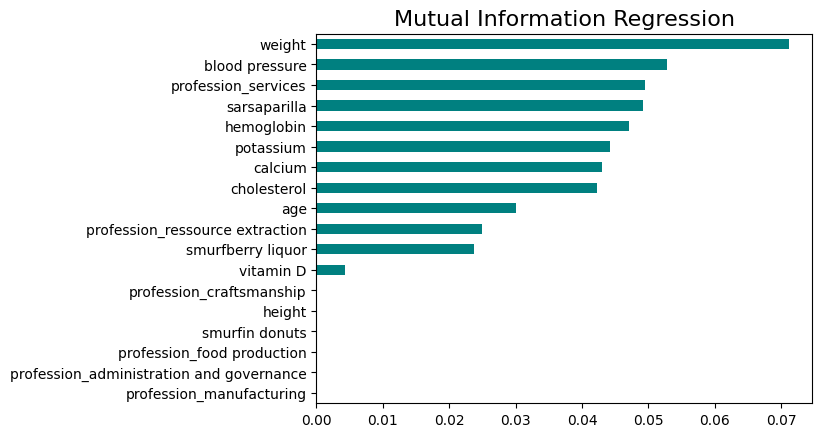

In [23]:
importances = mutual_info_regression(X, y)
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh', color = 'teal')

final_col = feat_importances[feat_importances > 0.01].index
plt.title('Mutual Information Regression', fontsize=16)
plt.savefig('../figures/mutual_info_regression.pdf', bbox_inches='tight')
plt.show()

# SelectKBest
def selectKBest(X, y, k):
    select_col = SelectKBest(mutual_info_regression, k=k)
    select_col.fit(X, y)
    return X[X.columns[select_col.get_support()]]


# SelectPercentile
def selectPercentile(X, y, percentile):
    select_col = SelectPercentile(mutual_info_regression, percentile=percentile)
    select_col.fit(X, y)
    return X[X.columns[select_col.get_support()]]

#### Fisher's score

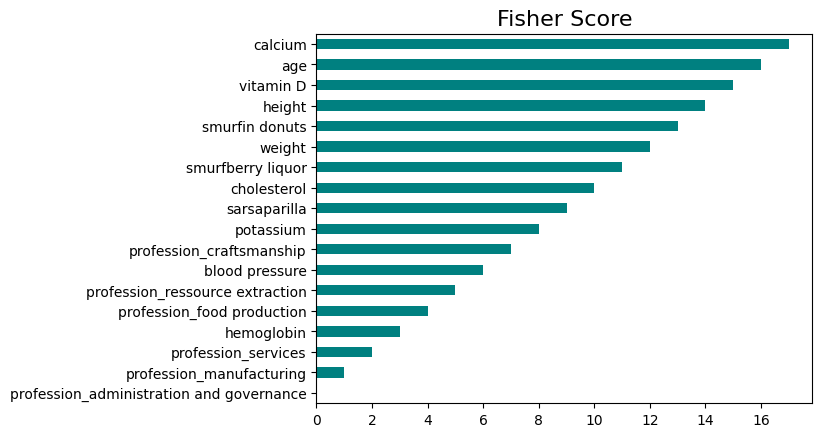

In [24]:
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
%matplotlib inline

X_numpy = X.to_numpy()
y_numpy = y.to_numpy()

# Calculating scores
ranks = fisher_score.fisher_score(X_numpy, y_numpy)

# Plotting the ranks
feat_importances = pd.Series(ranks, index=X.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh', color='teal')
plt.title('Fisher Score', fontsize=16)
plt.savefig('../figures/fisher_score.pdf', bbox_inches='tight')
plt.show()


#### Recursive feature elimination

In [168]:
def select_feat(X,y, estimator, n_features):
    rfe = RFECV(estimator, min_features_to_select=n_features, cv=KFold(5), n_jobs=-1)
    rfe.fit(X, y)
    return X[X.columns[rfe.support_]]

select_feat(X, y, RandomForestRegressor(), 5)

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,sarsaparilla,smurfberry liquor,vitamin D,weight
0,-1.024993,-0.400520,-1.361795,-1.565069,-0.558922,0.331238,-0.661149,-0.349855,0.655978,-0.615919,-0.962435
1,-1.147467,-1.225008,1.110102,-0.458686,-0.512067,0.306468,0.394345,-0.349855,-1.115163,-1.310925,-0.169138
2,1.118310,0.040415,0.813474,-0.487683,-1.408993,-0.362331,-1.314551,2.071660,-0.229592,-0.040114,-0.987849
3,-0.800456,-0.858066,1.406730,0.532526,0.893562,-0.387101,-0.862196,-0.349855,-0.229592,0.266982,0.209054
4,0.424288,0.261637,0.813474,0.711818,0.010023,0.504630,-1.951198,-1.157027,-0.229592,0.303348,0.010579
...,...,...,...,...,...,...,...,...,...,...,...
994,-1.576128,0.193685,-0.669664,-0.564056,1.362105,0.603711,1.248793,2.071660,0.655978,-1.092725,-0.319205
995,-0.698394,-0.983400,-0.026971,-1.558535,-0.150620,-0.510953,-0.007748,0.457316,0.655978,-0.373475,-0.523731
996,-0.290146,-1.003031,0.269657,-0.643696,-0.672711,-0.932048,0.176545,-0.349855,1.541549,-0.272456,-1.716399
997,-0.555508,-0.672329,-0.125847,0.712635,-0.284489,-0.659575,-1.281043,-0.349855,-0.229592,-1.797834,-1.991118


#### Random Forest Importance

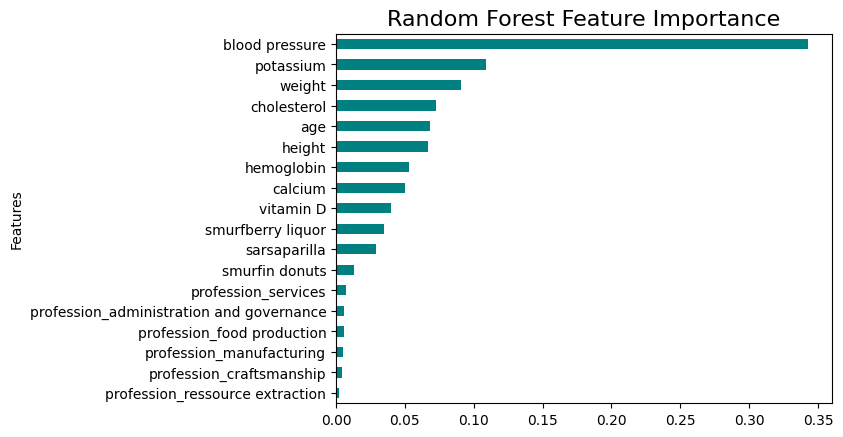

In [25]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest classifier with your hyperparameters
model = RandomForestRegressor(n_estimators=340)

# Fit the model to the data
model.fit(X, y)

# Get the importance of the resulting features
importances = model.feature_importances_

# Create a data frame for visualization
final_df = pd.DataFrame({'Features': pd.DataFrame(X).columns, 'Importances': importances})
final_df.set_index('Importances')

# Sort in ascending order for better visualization
final_df = final_df.sort_values('Importances', ascending=True)

# Plot the feature importances in bars
final_df.plot(kind='barh', color='teal', x='Features', y='Importances', legend=False)
plt.title('Random Forest Feature Importance', fontsize=16)
plt.savefig('../figures/random_forest_importance.pdf', bbox_inches='tight')

# Model Selection

#### SVM

In [173]:
n_features = [9, 12]
def SVR_model(X, y, col):
    model = SVR()
    param_grid = {
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    if col == '':
        grid_search.fit(X, y)
    else:
        grid_search.fit(X[col], y)

    print("Best parameters: ", grid_search.best_params_)
    print("Best RMSE: ", np.sqrt(-grid_search.best_score_))
    print()

    return {'best_params': grid_search.best_params_, 'best_rmse': np.sqrt(-grid_search.best_score_)}

best_rmse = 1000
best_params = {}
best_n = 0
best_strategy = ''

# Feature Selection : Correlation
for n in n_features:
    print("Number of features: ", n)
    X_train_selected = correl(X, y, n, False)['X']
    res = SVR_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Correlation'

# Feature Selection : SelectKBest
for n in n_features:
    print("Number of features: ", n)
    X_train_selected = selectKBest(X, y, n)
    res = SVR_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'SelectKBest'

# Feature Selection : Fisher Score
for n in n_features:
    print("Number of features: ", n)
    index = feat_importances
    colu = index.tail(n).index
    X_train_selected = X[colu]
    res = SVR_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Fisher Score'

# Feature Selection : RFE
for n in n_features:
    print("Number of features: ", n)
    X_train_selected = select_feat(X, y, RandomForestRegressor(), n)
    res = SVR_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'RFE'

# Feature Selection : Random Forest Importance
for n in n_features:
    print("Number of features: ", n)
    colu = final_df.tail(n)['Features']
    X_train_selected = X[colu]
    res = SVR_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Random Forest Importance'

# Testing the best model
model = SVR(**best_params)
print("Best parameters: ", best_params)
if best_strategy == 'Correlation':
    corr = correl(X, y, best_n, False)
    X_train_selected = corr['X']
    print(" Correlation: ", corr['top_features'])
elif best_strategy == 'SelectKBest':
    X_train_selected = selectKBest(X, y, best_n)
    print(" SelectKBest: ", X_train_selected.columns)
elif best_strategy == 'Fisher Score':
    colu = feat_importances
    X_train_selected = X[colu]
    print(" Fisher Score: ", colu)
elif best_strategy == 'RFE':
    X_train_selected = select_feat(X, y, RandomForestRegressor(), best_n)
    print(" RFE: ", X_train_selected.columns)
elif best_strategy == 'Random Forest Importance':
    colu = final_df.tail(best_n)['Features']
    X_train_selected = X[colu]
    print(" Random Forest Importance: ", colu)

model.fit(X_train_selected, y)
X_test_selected = X_test[X_train_selected.columns]
y_pred = model.predict(X_test_selected)
print("RMSE on test set: ", np.sqrt(mean_squared_error(y_test, y_pred)))    

Number of features:  9
Fitting 5 folds for each of 363 candidates, totalling 1815 fits
Best parameters:  {'C': 0.1, 'epsilon': 0.05, 'kernel': 'rbf'}
Best RMSE:  0.07271931382156183

Number of features:  12
Fitting 5 folds for each of 363 candidates, totalling 1815 fits
Best parameters:  {'C': 0.1, 'epsilon': 0.05, 'kernel': 'rbf'}
Best RMSE:  0.07229726811174357

Number of features:  9
Fitting 5 folds for each of 363 candidates, totalling 1815 fits
Best parameters:  {'C': 0.1, 'epsilon': 0.05, 'kernel': 'rbf'}
Best RMSE:  0.07535493250952882

Number of features:  12
Fitting 5 folds for each of 363 candidates, totalling 1815 fits
Best parameters:  {'C': 0.1, 'epsilon': 0.05, 'kernel': 'rbf'}
Best RMSE:  0.07426920715315814

Number of features:  9
Fitting 5 folds for each of 363 candidates, totalling 1815 fits
Best parameters:  {'C': 0.1, 'epsilon': 0.05, 'kernel': 'rbf'}
Best RMSE:  0.07888817048191443

Number of features:  12
Fitting 5 folds for each of 363 candidates, totalling 1815 

In [26]:
rmse = []
top_features = ['blood pressure', 'weight', 'sarsaparilla', 'cholesterol',
       'smurfin donuts', 'age', 'height', 'potassium', 'smurfberry liquor',
       'profession_administration and governance', 'profession_services',
       'profession_ressource extraction'] # From correlation with target
for k in range(1, 11):
    best_model = SVR(C=0.1, epsilon=0.05, kernel='rbf')
    best_model.fit(X[top_features], y)
    X_test_selected = X_test[top_features]
    y_pred = best_model.predict(X_test_selected)
    print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
                
mean_rmse = np.mean(rmse)
std_rmse = np.std(rmse)
print("Mean RMSE: ", mean_rmse)

RMSE:  0.07372451497482674
RMSE:  0.07372451497482674
RMSE:  0.07372451497482674
RMSE:  0.07372451497482674
RMSE:  0.07372451497482674
RMSE:  0.07372451497482674
RMSE:  0.07372451497482674
RMSE:  0.07372451497482674
RMSE:  0.07372451497482674
RMSE:  0.07372451497482674
Mean RMSE:  0.07372451497482672


#### DecisionTreeRegressor

In [ ]:
n_features = [9, 12]

def DecisionTree_model(X, y, col):
    model = DecisionTreeRegressor()

    param_grid = {
        'criterion': ['friedman_mse', 'poisson', 'absolute_error', 'squared_error'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 2, 5, 10, 20, 50, 100],
        'min_samples_split': [2, 5, 10, 20, 50, 100],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64],
        'max_features': ['sqrt', 'log2'],
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    if col == '':
        grid_search.fit(X, y)
    else:
        grid_search.fit(X[col], y)

    print("Best parameters: ", grid_search.best_params_)
    print("Best RMSE: ", np.sqrt(-grid_search.best_score_))
    print()

    return {'best_params': grid_search.best_params_, 'best_rmse': np.sqrt(-grid_search.best_score_)}

best_rmse = 1000
best_params = {}
best_n = 0
best_strategy = ''
for n in n_features:
    print("Number of features: ", n)
    X_train_selected = correl(X, y, n, False)['X']
    res = DecisionTree_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Correlation'

for n in n_features:
    print("Number of features: ", n)
    X_train_selected = selectKBest(X, y, n)
    res = DecisionTree_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'SelectKBest'

for n in n_features:
    print("Number of features: ", n)
    index = feat_importances
    colu = index.tail(n).index
    X_train_selected = X[colu]
    res = DecisionTree_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Fisher Score'

for n in n_features:
    print("Number of features: ", n)
    X_train_selected = select_feat(X, y, RandomForestRegressor(), n)
    res = DecisionTree_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'RFE'

for n in n_features:
    print("Number of features: ", n)
    colu = final_df.tail(n)['Features']
    X_train_selected = X[colu]
    res = DecisionTree_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Random Forest Importance'

model = DecisionTreeRegressor(**best_params)
print("Best parameters: ", best_params)
if best_strategy == 'Correlation':
    corr = correl(X, y, best_n, False)
    X_train_selected = corr['X']
    print(" Correlation: ", corr['top_features'])
elif best_strategy == 'SelectKBest':
    X_train_selected = selectKBest(X, y, best_n)
    print(" SelectKBest: ", X_train_selected.columns)
elif best_strategy == 'Fisher Score':
    colu = feat_importances
    X_train_selected = X[colu]
    print(" Fisher Score: ", colu)
elif best_strategy == 'RFE':
    X_train_selected = select_feat(X, y, RandomForestRegressor(), best_n)
    print(" RFE: ", X_train_selected.columns)
elif best_strategy == 'Random Forest Importance':
    colu = final_df.tail(best_n)['Features']
    X_train_selected = X[colu]
    print(" Random Forest Importance: ", colu)

model.fit(X_train_selected, y)
X_test_selected = X_test[X_train_selected.columns]
y_pred = model.predict(X_test_selected)
print("RMSE on test set: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Number of features:  9
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'friedman_mse', 'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 32, 'min_samples_split': 5, 'splitter': 'best'}
Best RMSE:  0.07480552244650841

Number of features:  12
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits
Best parameters:  {'criterion': 'squared_error', 'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 20, 'splitter': 'best'}
Best RMSE:  0.07562394672439124

Number of features:  9
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 5, 'splitter': 'best'}
Best RMSE:  0.07522920494550987

Number of features:  12
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits
Best parameters:  {'criterion': 'poisson', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 20, 'splitter': 'best'}
Best RMSE:  0.07573634482245799

Number of features:  9
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 100, 'splitter': 'best'}
Best RMSE:  0.08036630869869679

Number of features:  12
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'poisson', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 50, 'splitter': 'random'}
Best RMSE:  0.07660468564366602

Number of features:  9
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 5, 'splitter': 'best'}
Best RMSE:  0.0757157228061489

Number of features:  12
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Best RMSE:  0.07691965467444214

Number of features:  9
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits
Best parameters:  {'criterion': 'poisson', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 20, 'splitter': 'best'}
Best RMSE:  0.07420443741782996

Number of features:  12
Fitting 5 folds for each of 4704 candidates, totalling 23520 fits
Best parameters:  {'criterion': 'poisson', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 32, 'min_samples_split': 50, 'splitter': 'best'}
Best RMSE:  0.07569301291136663

Best parameters:  {'criterion': 'poisson', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 20, 'splitter': 'best'}
 Random Forest Importance:  10         vitamin D
2            calcium
4         hemoglobin
5             height

/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [27]:
rmse = []
top_features = ['calcium', 'hemoglobin', 'height', 'age', 'cholesterol', 'weight', 'potassium', 'blood pressure'] # From correlation with target
for k in range(1, 11):
    best_model = DecisionTreeRegressor(criterion='poisson', max_depth=5, max_features='sqrt', min_samples_leaf=8, min_samples_split=20, splitter='best')
    best_model.fit(X[top_features], y)
    X_test_selected = X_test[top_features]
    y_pred = best_model.predict(X_test_selected)
    print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
                
mean_rmse = np.mean(rmse)
std_rmse = np.std(rmse)
print("Mean RMSE: ", mean_rmse)

RMSE:  0.07942513264660724
RMSE:  0.08713666375188293
RMSE:  0.08882488203780345
RMSE:  0.08114777656233023
RMSE:  0.08269750631040299
RMSE:  0.08558664432573167
RMSE:  0.0819540566540609
RMSE:  0.08631993750385512
RMSE:  0.08487799581233003
RMSE:  0.08460866171434057
Mean RMSE:  0.0842579257319345


#### RandomForestRegressor

In [175]:
n_features = [9, 12]

def RandomForest_model(X, y, col):
    model = RandomForestRegressor()

    param_grid = {
        'n_estimators': [100, 150, 200, 250, 300],
        'criterion': ['friedman_mse', 'squared_error'],
        'max_depth': [None, 5, 10, 15, 20, 30, 50],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=2)
    if col == '':
        grid_search.fit(X, y)
    else:
        grid_search.fit(X[col], y)

    print("Best parameters: ", grid_search.best_params_)
    print("Best RMSE: ", np.sqrt(-grid_search.best_score_))
    print()

    return {'best_params': grid_search.best_params_, 'best_rmse': np.sqrt(-grid_search.best_score_)}
best_rmse = 1000
best_params = {}
best_n = 0
best_strategy = ''
for n in n_features:
    print("Number of features: ", n)
    X_train_selected = correl(X, y, n, False)['X']
    res = RandomForest_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Correlation'

for n in n_features:
    print("Number of features: ", n)
    X_train_selected = selectKBest(X, y, n)
    res = RandomForest_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'SelectKBest'

for n in n_features:
    print("Number of features: ", n)
    index = feat_importances
    colu = index.tail(n).index
    X_train_selected = X[colu]
    res = RandomForest_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Fisher Score'

for n in n_features:
    print("Number of features: ", n)
    X_train_selected = select_feat(X, y, RandomForestRegressor(), n)
    res = RandomForest_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'RFE'

for n in n_features:
    print("Number of features: ", n)
    colu = final_df.tail(n)['Features']
    X_train_selected = X[colu]
    res = RandomForest_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Random Forest Importance'

model = RandomForestRegressor(**best_params)
print("Best parameters: ", best_params)
if best_strategy == 'Correlation':
    corr = correl(X, y, best_n, False)
    X_train_selected = corr['X']
    print(" Correlation: ", corr['top_features'])
elif best_strategy == 'SelectKBest':
    X_train_selected = selectKBest(X, y, best_n)
    print(" SelectKBest: ", X_train_selected.columns)
elif best_strategy == 'Fisher Score':
    colu = feat_importances
    X_train_selected = X[colu]
    print(" Fisher Score: ", colu)
elif best_strategy == 'RFE':
    X_train_selected = select_feat(X, y, RandomForestRegressor(), best_n)
    print(" RFE: ", X_train_selected.columns)
elif best_strategy == 'Random Forest Importance':
    colu = final_df.tail(best_n)['Features']
    X_train_selected = X[colu]
    print(" Random Forest Importance: ", colu)

model.fit(X_train_selected, y)
X_test_selected = X_test[X_train_selected.columns]
y_pred = model.predict(X_test_selected)
print("RMSE on test set: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Number of features:  9
Fitting 5 folds for each of 420 candidates, totalling 2100 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best RMSE:  0.06904805405145929

Number of features:  12
Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best parameters:  {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE:  0.06904657096471892

Number of features:  9
Fitting 5 folds for each of 420 candidates, totalling 2100 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best RMSE:  0.07094561043758968

Number of features:  12
Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best parameters:  {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best RMSE:  0.06972123749295948

Number of features:  9
Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best parameters:  {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Best RMSE:  0.07763575613718442

Number of features:  12
Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best parameters:  {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Best RMSE:  0.06949200080844695

Number of features:  9
Fitting 5 folds for each of 420 candidates, total

/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 250}
Best RMSE:  0.06954334600090196

Number of features:  9
Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best parameters:  {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE:  0.07064395115719214

Number of features:  12
Fitting 5 folds for each of 420 candidates, totalling 2100 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best RMSE:  0.06946895407080646

Best parameters:  {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
 Correlation:  Index(['blood pressure', 'weight', 'sarsaparilla', 'cholesterol',
       'smurfin donuts', 'age', 'height', 'potassium', 'smurfberry liquor',
       'profession_administration and governance', 'profession_services',
       'profession_ressource extraction'],
      dtype='object')
RMSE on test set:  0.07202591527524975


In [29]:
rmse = []
top_features = ['blood pressure', 'weight', 'sarsaparilla', 'cholesterol',
       'smurfin donuts', 'age', 'height', 'potassium', 'smurfberry liquor',
       'profession_administration and governance', 'profession_services',
       'profession_ressource extraction'] # From correlation with target
for k in range(1, 11):
    best_model = RandomForestRegressor(criterion='friedman_mse', max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100)
    best_model.fit(X[top_features], y)
    X_test_selected = X_test[top_features]
    y_pred = best_model.predict(X_test_selected)
    print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
                
mean_rmse = np.mean(rmse)
std_rmse = np.std(rmse)
print("Mean RMSE: ", mean_rmse)

RMSE:  0.07301592288786757
RMSE:  0.07301362024625027
RMSE:  0.07233212841799079
RMSE:  0.07253192266083283
RMSE:  0.07275914481510662
RMSE:  0.07292176443637848
RMSE:  0.07241128487564347
RMSE:  0.07242591516896486
RMSE:  0.07244888498584212
RMSE:  0.07295379534708928
Mean RMSE:  0.07268143838419663


#### MLPRegressor

In [176]:
n_features = [9, 12]

def MLPRegressor_model(X, y, col):
    model = MLPRegressor()

    param_grid = {
        'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=2)
    if col == '':
        grid_search.fit(X, y)
    else:
        grid_search.fit(X[col], y)

    print("Best parameters: ", grid_search.best_params_)
    print("Best RMSE: ", np.sqrt(-grid_search.best_score_))
    print()

    return {'best_params': grid_search.best_params_, 'best_rmse': np.sqrt(-grid_search.best_score_)}
best_rmse = 1000
best_params = {}
best_n = 0
best_strategy = ''
for n in n_features:
    print("Number of features: ", n)
    X_train_selected = correl(X, y, n, False)['X']
    res = MLPRegressor_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Correlation'

for n in n_features:
    print("Number of features: ", n)
    X_train_selected = selectKBest(X, y, n)
    res = MLPRegressor_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'SelectKBest'

for n in n_features:
    print("Number of features: ", n)
    index = feat_importances
    colu = index.tail(n).index
    X_train_selected = X[colu]
    res = MLPRegressor_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Fisher Score'

for n in n_features:
    print("Number of features: ", n)
    X_train_selected = select_feat(X, y, RandomForestRegressor(), n)
    res = MLPRegressor_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'RFE'

for n in n_features:
    print("Number of features: ", n)
    colu = final_df.tail(n)['Features']
    X_train_selected = X[colu]
    res = MLPRegressor_model(X_train_selected, y, '')
    if res['best_rmse'] < best_rmse:
        best_rmse = res['best_rmse']
        best_params = res['best_params']
        best_n = n
        best_strategy = 'Random Forest Importance'

model = MLPRegressor(**best_params)
print("Best parameters: ", best_params)
if best_strategy == 'Correlation':
    corr = correl(X, y, best_n, False)
    X_train_selected = corr['X']
    print(" Correlation: ", corr['top_features'])
elif best_strategy == 'SelectKBest':
    X_train_selected = selectKBest(X, y, best_n)
    print(" SelectKBest: ", X_train_selected.columns)
elif best_strategy == 'Fisher Score':
    colu = feat_importances
    X_train_selected = X[colu]
    print(" Fisher Score: ", colu)
elif best_strategy == 'RFE':
    X_train_selected = select_feat(X, y, RandomForestRegressor(), best_n)
    print(" RFE: ", X_train_selected.columns)
elif best_strategy == 'Random Forest Importance':
    colu = final_df.tail(best_n)['Features']
    X_train_selected = X[colu]
    print(" Random Forest Importance: ", colu)

model.fit(X_train_selected, y)
X_test_selected = X_test[X_train_selected.columns]
y_pred = model.predict(X_test_selected)
print("RMSE on test set: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Number of features:  9
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best RMSE:  0.06956360363300197

Number of features:  12
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best RMSE:  0.07042513744953866

Number of features:  9
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'solver': 'adam'}
Best RMSE:  0.07286786764696707

Number of features:  12
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best RMSE:  0.07296147632885011

Number of features:  9
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best RMSE:  0.075780865453891

Number of features:  12
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'solver': 'adam'}
Best RMSE:  0.0708816293305134

Number of features:  9


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best RMSE:  0.07173073177947288

Number of features:  12


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best RMSE:  0.07094245195697192

Number of features:  9
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best RMSE:  0.07131638204317467

Number of features:  12
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/baptiste/anaconda

Best parameters:  {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best RMSE:  0.07009288734347023

Best parameters:  {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
 Correlation:  Index(['blood pressure', 'weight', 'sarsaparilla', 'cholesterol',
       'smurfin donuts', 'age', 'height', 'potassium', 'smurfberry liquor'],
      dtype='object')
RMSE on test set:  0.0695717296239422


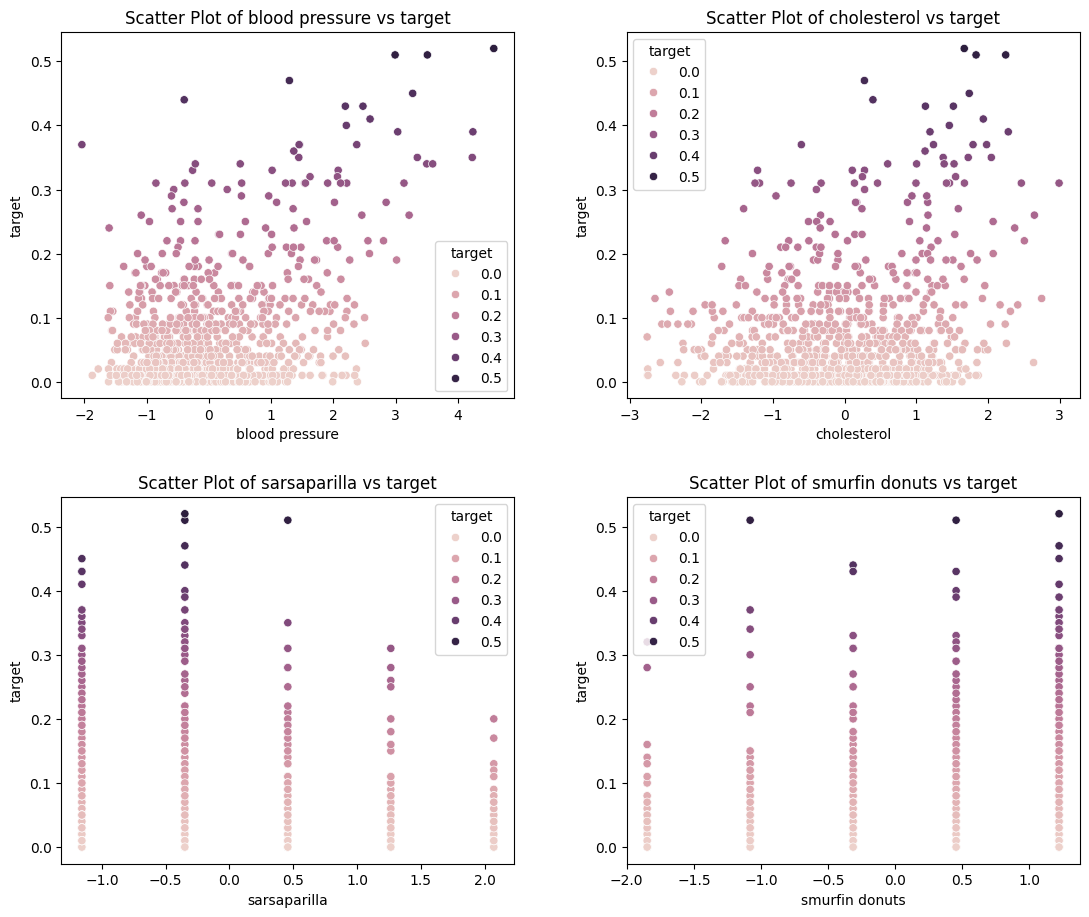

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Données à visualiser
individual = ['blood pressure', 'cholesterol', 'sarsaparilla', 'smurfin donuts']
two = ['sarsaparilla', 'smurfin donuts']
features = individual + [('blood pressure', f) for f in two] + [('cholesterol', f) for f in two]

# Initialiser la figure 3x3
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 3x3 grid, ajustez la taille selon vos besoins
fig.tight_layout(pad=5.0)  # Espacement entre les sous-figures

# Créer les sous-graphiques
for idx, ax in enumerate(axes.flatten()):
    if idx < len(features):
        if isinstance(features[idx], str):  # Scatter individuel
            sns.scatterplot(x=features[idx], y='target', hue='target', data=X, ax=ax)
            ax.set_title(f'Scatter Plot of {features[idx]} vs target', fontsize=12)
            ax.set_xlabel(features[idx], fontsize=10)
            ax.set_ylabel('target', fontsize=10)
    else:
        ax.axis('off')  # Si moins de 9 graphiques, désactiver les axes inutilisés

# Afficher la figure
plt.savefig('../figures/analysis.pdf', bbox_inches='tight')
plt.show()

#### Best model

In [ ]:
rmse = []
top_features = ['blood pressure', 'weight', 'sarsaparilla', 'cholesterol',
       'smurfin donuts', 'age', 'height', 'potassium', 'smurfberry liquor'] # From correlation with target
for k in range(1, 11):
    best_model = MLPRegressor(activation='relu', alpha=0.1, hidden_layer_sizes=(100, 100, 100), learning_rate='constant', solver='adam')
    best_model.fit(X[top_features], y)
    X_test_selected = X_test[top_features]
    y_pred = best_model.predict(X_test_selected)
    print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
                
mean_rmse = np.mean(rmse)
std_rmse = np.std(rmse)
print("Mean RMSE: ", mean_rmse)

RMSE:  0.06911641181991192
RMSE:  0.06884476366784022
RMSE:  0.06866364707291128
RMSE:  0.06936092477203289
RMSE:  0.06910092591348181
RMSE:  0.06929190095760172
RMSE:  0.0688645407724509
RMSE:  0.0686583139496725
RMSE:  0.06984776764988879
RMSE:  0.0695865032626557
Mean RMSE:  0.06913356998384476
